<a href="https://colab.research.google.com/github/arumshin-dev/python_conda_jupyter/blob/main/codeit/3_3_3_GPT_%E1%84%89%E1%85%A1%E1%84%8C%E1%85%A5%E1%86%AB%E1%84%92%E1%85%A1%E1%86%A8%E1%84%89%E1%85%B3%E1%86%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT

## GPT 학습을 위한 데이터세트 구성

GPT 모델 또한 일반적으로 사전학습과 미세조정 두가지의 학습 단계가 존재합니다.

- **사전 학습**
    * 웹 텍스트나 책, 논문, 뉴스 등 다양한 출처의 방대한 텍스트 데이터를 활용하여 사전학습을 진행
    * 특수한 라벨이나 태그가 달려 있지 않으며, 자연어 형태(대체로 가공되지 않은(unlabeled) 텍스트 형태)로 학습
    * 욕설・중복 등 품질이 매우 낮은 텍스트를 걸러내는 등의 기본적인 전처리(cleaning) 작업만 진행

- **미세조정**
    * 적절한 대화가 유도 되도록 프폼프트와 답변을 라벨링한 대화형 학습 데이터(Instruction tuning 데이터)세트를 구성하여 하여 미세조정
    * 시스템 역할, 사용자 역할, 도우미 역할 등 **역할 토큰(role token)**과 문장 시작, 문장 끝 등의 **특수 토큰**을 추가하여 대화의 맥락, 혹은 지시문의 종류 등을 명확히 파악하도록 유도


이번 예시에서는 간단한 모델 구현과 학습 과정만을 보기 위해 사전학습과 미세조정을 나누지 않고 [AIHUB](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=86) 한국어 감성 대화 말뭉치를 부분적으로 활용하여 특수토큰이 포함된 질의,응답 데이터세트로 학습을 진행합니다.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import sentencepiece as spm
import pandas as pd
import numpy as np

df = pd.read_csv(f'./train.csv')
df[['HS01','SS01']]

,HS01,SS01
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...
...,...,...
51623,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.,경제적인 문제 때문에 막막하시군요. 마음이 편치 않으시겠어요.
51624,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.,건강에 대한 어려움 때문에 기분이 좋지 않으시군요. 속상하시겠어요.
51625,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.,노후 준비에 대한 어려움 때문에 걱정이 많으시겠어요.
51626,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.,가족과의 문제 때문에 속상하시겠어요.


### Autoregressive 학습을 위한 데이터세트

GPT는 Transformer의 디코더 구조를 활용한 모델이므로 기본적으로 자기회귀(Autoregressive) 방식으로 왼쪽에서 오른쪽 방향으로 순차적 토큰을 생성합니다.  
따라서 학습을 위한 입력 데이터는 **캐주얼(Causal) 마스크**를 통해 미래 토큰을 가려주어야 하며, 입력-라벨 구조는 단순히 입력 토큰을 **왼쪽으로 한칸씩 쉬프트** 한 토큰으로 구성이됩니다.

    원문: [오늘, 수업은, GPT, 텍스트, 생성, 수업, 이다]

    입력: [오늘, 수업은, GPT, 텍스트, 생성, 수업]

    라벨: [수업은, GPT, 텍스트, 생성, 수업, 이다]


In [ ]:
# BPE :바이트 페어 인코딩(Byte Pair Encoding, BPE)
import os, re

# 추가 쓰기모드로 텍스트 파일 열기
with open('train.txt', 'w', encoding='utf-8') as f:
  for text in df['HS01']:
        text = str(text)
        text = re.sub(r'[^\w\s]', '', text)     # 특수문자 제거
        text = re.sub(r'[\n\t]', ' ', text)     # 줄바꿈, 탭 제거
        text = re.sub(r'\s+', ' ', text)        # 연속된 공백 제거
        text = re.sub(r'\?{2,}', '?', text)     # ?? → ?
        text= text.strip()                      # 문장 양끝 공백 제거
        try:
            f.write(text+'\n')
        except:
                pass

# 저장 경로 생성
os.makedirs('./bpe', exist_ok=True)

spm.SentencePieceTrainer.train(
    input='train.txt',                      # 텍스트 뭉치 파일
    model_prefix='./bpe/spm_krsent',        # 출력 모델 파일 이름
    vocab_size=2000                         # 토큰 개수
)

spm.SentencePieceTrainer.train(input='train.txt',               # 텍스트 뭉치 파일
                            model_prefix='./bpe/spm_krsent',    # 출력 모델 파일 이름
                            vocab_size=4000,                    # 토큰 개수
                            bos_id=1,
                            eos_id=2,
                            unk_id=3,
                            pad_id=0
                            )

In [ ]:
class SPDataSet(Dataset):
    def __init__(self, sp, max_len):
        self.max_len = max_len
        self.df = pd.read_csv(f'./train.csv')[['HS01','SS01']]
        self.sp = sp

    def zero_pad(self, tok):
        if len(tok) >= self.max_len:
            return tok[:self.max_len]
        else:
            padding = np.zeros(self.max_len)
            padding[:len(tok)] = tok
            return padding

    def __len__(self):
        return (len(self.df))

    def __getitem__(self, i):
        sent = self.df.iloc[i]
        sent1 = self.sp.encode_as_ids(sent['HS01'])
        sent2 = self.sp.encode_as_ids(sent['SS01'])

        # 문장 구분을 위해 bos 토큰과 eos 토큰 추가
        inp = sent1 + [self.sp.bos_id()] + sent2 + [self.sp.eos_id()]

        # 문장이 끝나면 제로 패딩
        input_ids = self.zero_pad(inp)

        # 입력 토큰을 왼쪽으로 한 칸 쉬프트하여 라벨링
        tar_id = np.zeros(self.max_len)
        tar_id[:-1] = input_ids[1:]

        # 패딩 마스크
        mask = torch.eq(torch.Tensor(input_ids), 0)

        return torch.Tensor(input_ids), torch.Tensor(tar_id), mask


sp = spm.SentencePieceProcessor(model_file=f'./bpe/spm_krsent.model')
dataset = SPDataSet(sp, 60)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for inp, tar, mask in dataloader:
    print(inp.long())
    print(tar.long())
    print(mask)
    break

tensor([[  29,  126,  466,    8, 1432, 2058,   47,  119,    6,  347,   73,   42,
         1107,   64,    3,  156, 1090,   10,  510,    3,    1,  606, 1107,  702,
         1801,   40,  117,  408,    4, 3990,  799,  143,  427,  783,    3,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[ 126,  466,    8, 1432, 2058,   47,  119,    6,  347,   73,   42, 1107,
           64,    3,  156, 1090,   10,  510,    3,    1,  606, 1107,  702, 1801,
           40,  117,  408,    4, 3990,  799,  143,  427,  783,    3,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False

> 실제 채팅형 모델에서는 `/system` `/user` `/assistant` 와 같은 역할(Role)을 나타내는 토큰으로 더욱 정교하게 프롬프트를 구성합니다.

### Causal Mask

Causal Mask(look-ahead)는 Transformer에서 구현한 방식과 동일하게 bool 타입의 삼각 행렬로 구현하며, 데이터세트 내부가 아닌 모델 내부에서 적용합니다.

In [ ]:
causal_mask = torch.ones(10, 10, dtype=torch.bool)

# 상삼각 부분만 True
causal_mask = torch.triu(causal_mask, diagonal=1)
causal_mask

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

> nn.MultiheadAttention을 사용하므로 마스킹 될 위치를 True로 설정합니다.

## GPT 모델링

GPT는 Transformer의 디코더 구조의 아케텍처를 기반으로 합니다. 정확하게는 Transformer디코더는 두개의 멀티헤드 어텐션이 있지만, GPT는 셀프어텐션만 진행하는 하나의 멀티헤드 어텐션만 활용합니다.

<center><img src="https://drive.google.com/uc?export=view&id=1R5hb_yAvd1MQyCkWRNb7CUKhamKJ4rhU" width="600"/></center>



### 멀티헤드 블록

nn.MultiheadAttention -> Skip -> Norm -> Feed Forward -> Skip -> Norm 과정으로 진행되는 멀티헤드 블록 모듈을 구현합니다.

In [ ]:
import math
import torch
from torch import nn

class MTBlock (nn.Module):
    """
    🏗️ Multi-Head Transformer Block
    - Transformer의 기본 구성 요소
    - Self-Attention + Feed Forward Network
    """
    def __init__(self, em_dim, nhead, feed_dim=512, gelu=False, dropout=0.):
        super(MTBlock, self).__init__()

        # 멀티헤드
        self.mha = nn.MultiheadAttention(em_dim, nhead, dropout=dropout, batch_first=True)
        self.nhead = nhead

        # Feed Forward
        if gelu:
            self.active = nn.GELU()
        else:
            self.active = nn.ReLU()

        self.ffn = nn.Sequential(
            nn.Linear(em_dim, feed_dim),
            self.active,
            nn.Dropout(dropout),
            nn.Linear(feed_dim, em_dim)
        )

        # 정규화
        self.norm1 = nn.LayerNorm(em_dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(em_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self,
        x,
        attn_mask=None, key_padding_mask=None
    ):
        # 셀프 어텐션 + 패딩 마스크 + 캐주얼 마스크
        attn_output,_ = self.mha(
            x, x, x,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=False
        )
        # 스킵, 정규화
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)

        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)

        return out2

### 포지션 인코딩

GPT 역시 위치정보를 입력하기 위한 포지션 인코딩이 필요합니다. 기존 방식과 동일하게 포지션 인코딩을 위한 모듈을 만듭니다.  

In [ ]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim, max_pos=10000):
        super().__init__()
        # 위치 인덱스
        position = torch.arange(max_pos).unsqueeze(1)
        # 위치에 따른 각도 추출
        # 지수(exp)와 로그(log)를 함께써 지수승 형태(**)를 만들어 사용
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))

        # 제로 텐서를 만들고 sin,cos 결과 할당
        pe = torch.zeros(1, max_pos, embed_dim)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe) # 학습되지 않는 모듈로 저장

    def forward(self, x):
        # 임베딩이 입력되면 포지션과 더하여 반환
        x = x + self.pe[:, :x.size(1), :]
        return x

### 생성 함수가 추가된 모델 구현

구현한 `포지션 인코딩`, `멀티헤드 블록`, `nn.Embedding` 레이어, 토큰을 분류하기 위한 선형 레이어(`nn.Linear(embed_dim, vocab_size)`)를 이용하여 토큰을 생성하는 GPT 모델을 구현합니다.  
이때, 입력 토큰이 멀티헤드 블록에 입력되기 이전에 **캐주얼 마스크**를 생성하여 같이 입력해 줍니다.

완성된 GPT 모델도 학습을 위한 `forward` 함수와 별개로, Transformer모델과 동일하게 자기회귀 방식으로 토큰을 예측하는 `generate` 함수를 따로 구현해 줍니다.

**generate 함수**
- 프롬프트로 작성될 입력 토큰셋을 받아 자기회귀(Autoregressive)방식으로 토큰을 생성
- 최대 토큰 길이를 설정하여 토큰 예측을 반복하고 문장 끝 토큰이 나오는 경우 반복을 중단
- 토큰 id를 실제 단어 토큰으로 변환하여 출력


In [ ]:
class SimpleGPT(nn.Module):
    def __init__(
            self,
            vocab_size,
            embed_dim=128,
            num_heads=4,
            feed_dim=256,
            num_layers=4,
            dropout=0.1
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # 임베딩 및 포지션 인코딩
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)
        self.dropout = nn.Dropout(dropout)

        # 여러 층의 멀티헤드 Block
        self.layers = nn.ModuleList([
            MTBlock(embed_dim, num_heads, feed_dim, gelu=True, dropout=dropout)
            for _ in range(num_layers)
        ])

        # 토큰 분류를 위한 Head(선형레이어)
        self.lm_head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, key_padding_mask=None):
        bsz, seq_len = x.shape
        device = x.device

        # 임베딩 + 포지션 인코딩
        emb = self.token_emb(x)
        scale = torch.sqrt(torch.tensor(self.embed_dim, dtype=torch.float, device=device))
        x = emb * scale
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Casual Mast 생성(미래 토큰을 보지 못하도록)
        #   1) Casual Mask 생성 (미래 토큰을 보지 못하게 막는 마스크)
        causal_mask = torch.ones(seq_len, seq_len, dtype=torch.bool, device=device)
        #   2) 상삼각행렬(triu)로 바꿔서,
        #      현재 위치(i)가 future 위치(j > i)를 바라보지 못하도록 차단
        causal_mask = torch.triu(causal_mask, diagonal=1)       # torch.triu: 대각선(diagonal) 기준으로 그 위쪽을 남기고 아래쪽은 0으로 만드는 연산

        # Transformer Block 반복
        for layer in self.layers:
            x = layer(
                x,
                attn_mask=causal_mask,
                key_padding_mask=key_padding_mask
            )

        # 단어 사전 크기만큼 점수(logit) 계산
        logits = self.lm_head(x)  # (bsz, seq_len, vocab_size)
        return logits

    @torch.no_grad()
    def generate(self, start_tokens, end_token=None, max_new_tokens=50):
        # start_tokens: 프롬프트로 입력된 토큰셋 (batch_size, cur_len)
        # 하나의 프롬프트가 입력되므로 batch_size=1 (여러 배치 사용시 패딩 마스크 필요)
        generated = start_tokens.clone()

        # 최대 토큰 길이만큼 반복
        for _ in range(max_new_tokens):

            # forward 함수로 토큰 로짓 출력
            logits = self.forward(generated) # (batch_size, cur_len, voacb_size)

            # 마지막 토큰 위치의 로짓만 가져옴 (batch_size, vocab_size)
            next_token_logit = logits[:, -1, :]
            next_token = torch.argmax(next_token_logit, dim=-1, keepdim=True) # (batch_size, 1)
            # 이전 토큰과 cat 결합
            generated = torch.cat([generated, next_token], dim=1)

            if end_token is not None and next_token == end_token:
                break

        return generated

vocab_size = sp.get_piece_size()
model = SimpleGPT(vocab_size=vocab_size)
with torch.no_grad():
    for inp, tar, mask in dataloader:
        logits = model(inp.long(), mask)
        print(logits.shape)
        pred = model.generate(inp.long()[:,:10], max_new_tokens=50)
        print(pred)
        break

torch.Size([1, 60, 4000])
tensor([[  55,    5,   29,    9,  414,    5,   21,    7,    4, 3739, 3434, 3743,
         3771, 3873, 3765, 1324, 3234, 1376, 3293, 3654,  952, 2961, 2538, 1619,
         2865, 2885, 1357, 2995, 2428, 2783, 1927, 3157,    4,  200, 1991,  744,
         1334, 3702, 2333,  281,  117, 1282, 1773, 3901, 1267, 1850, 1157,  663,
          565,  473,   34, 1397, 1468, 2159,  450, 2636, 3657, 2104, 2488, 3442]])


### 모델 학습하기

구현한 데이터세트를 활용하 GPT 모델을 학습합니다.
- CrossEntropyLoss
    * 토큰 분류를 위한 크로스엔트로피
    * 패딩 로짓은 무시가 되게 `ignore_index` 옵션을 추가
    * 시퀀스 길이와 배치를 곱하여 2차원 구조로 만들어 연산
    
- AdamW 옵티마이져
    * weight decay를 활용하여 가중치가 과하게 커지는것을 방지해 과적합을 방지 할 수 있음
    * Adam에서 weight decay는, 모멘트 업데이트와 weight decay 항이 같이 섞여 그레디언트가 왜곡되는 문제가 발생
    * AdamW는 파라미터 업데이트와 weight decay를 별개의 단계로 수행하여 정확한 L2 정규화를 만듬

In [ ]:
seq_len = 60
embed_dim = 128
num_heads = 4
feed_dim = 256
num_layers = 4
num_epochs = 50
batch_size = 64
lr = 1e-4

# 데이터세트 구성
sp = spm.SentencePieceProcessor(model_file=f'./bpe/spm_krsent.model')
vocab_size = sp.get_piece_size()

dataset = SPDataSet(sp, seq_len)
generator1 = torch.Generator().manual_seed(42)
test_dataset, train_dataset = random_split(dataset, [0.2, 0.8], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'train dataset size: {len(train_dataset)}')
print(f'test dataset size: {len(test_dataset)}')

# 모델 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleGPT(vocab_size, embed_dim, num_heads, feed_dim, num_layers).to(device)

# 옵티마이져, 손실 생성
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

train dataset size: 41302
test dataset size: 10326


In [ ]:
# 손실 계산시 형상 변환
def loss_function(tar, pred, pad_token=0):
    # pred shape: (batch_size, seq_len, vocab_size)
    # tar shape: (batch_size, seq_len)
    # pred shape to (batch_size * seq_len, vocab_size)
    pred_reshaped = pred.view(-1, pred.size(-1))
    tar_reshaped = tar.reshape(-1)
    return loss_fn(pred_reshaped, tar_reshaped)

train_loss = []
val_loss = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for step, (input_ids, tar_ids, mask) in enumerate(train_loader):
        input_ids = input_ids.long().to(device)
        tar_ids = tar_ids.long().to(device)
        key_padding_mask = mask.to(device)

        outputs = model(input_ids, key_padding_mask=key_padding_mask)

        loss = loss_function(tar_ids, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (step + 1) % 200 == 0:
            step_loss = total_loss / (step + 1)
            print(f"Epoch {epoch+1} Step {step+1} Loss: {step_loss}")

    avg_loss = total_loss / len(train_loader)
    print(f"Train ===> Epoch {epoch+1} Loss: {avg_loss}")
    train_loss.append(avg_loss)

    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for input_ids, tar_ids, mask in val_loader:
            input_ids = input_ids.long().to(device)
            tar_ids   = tar_ids.long().to(device)
            key_padding_mask = mask.to(device)

            outputs = model(input_ids, key_padding_mask=key_padding_mask)

            loss = loss_function(tar_ids, outputs)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Val ===> Epoch {epoch+1} Loss: {avg_loss}")
    val_loss.append(avg_loss)


Epoch 1 Step 200 Loss: 6.875391557216644
Epoch 1 Step 400 Loss: 6.3025881540775295
Epoch 1 Step 600 Loss: 6.013150996367137
Train ===> Epoch 1 Loss: 5.962264285368078
Val ===> Epoch 1 Loss: 5.240658948450912
Epoch 2 Step 200 Loss: 5.1915063118934635
Epoch 2 Step 400 Loss: 5.124720733165741
Epoch 2 Step 600 Loss: 5.058502278327942
Train ===> Epoch 2 Loss: 5.04446613308815
Val ===> Epoch 2 Loss: 4.792014592959557
Epoch 3 Step 200 Loss: 4.793300511837006
Epoch 3 Step 400 Loss: 4.743618850708008
Epoch 3 Step 600 Loss: 4.7033247375488285
Train ===> Epoch 3 Loss: 4.694205948442867
Val ===> Epoch 3 Loss: 4.500209496345049
Epoch 4 Step 200 Loss: 4.53206615447998
Epoch 4 Step 400 Loss: 4.498564578294754
Epoch 4 Step 600 Loss: 4.469618638356526
Train ===> Epoch 4 Loss: 4.465226355720969
Val ===> Epoch 4 Loss: 4.304008972497634
Epoch 5 Step 200 Loss: 4.339655749797821
Epoch 5 Step 400 Loss: 4.323917728662491
Epoch 5 Step 600 Loss: 4.305819989045461
Train ===> Epoch 5 Loss: 4.302481563467729
Val =

### 모델 평가

학습 손실과 평가 손실을 비교하여 모델의 학습정도를 평가하고 generate 함수를 이용하여 텍스트를 생성해 봅니다.

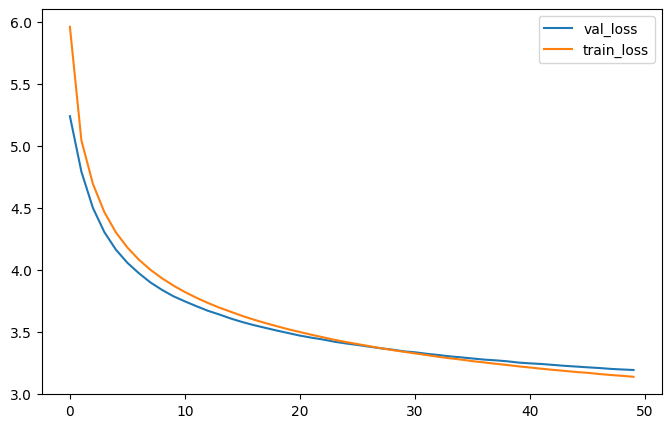

In [ ]:
import matplotlib.pyplot as plt

eps = range(len(train_loss))

fig = plt.figure(figsize=(8,5))
plt.plot(eps, val_loss, label = 'val_loss')
plt.plot(eps, train_loss, label = 'train_loss')
plt.legend()


Train Loss와 Val Loss가 함께 감소하며 수렴하고 있어 과적합 없이 안정적으로 학습되고 있습니다.

텍스트 생성 예시를 보기위해 평가 데이터세트에서 입력 토큰을 bos 토큰 기준으로 잘라 질문 토큰만 입력하여 응답 토큰이 잘 생성되는지 확인합니다.

In [ ]:
# 예측 텍스트에서 eos토큰을 잘라 패딩을 제거
def decode_tokens(token_ids):
    """
    🎯 목적: 토큰 ID를 텍스트로 변환 (특수 토큰 제거)

    입력 예시: [234, 567, 890, 2, 0, 0]
               └─ 실제 단어 ─┘ ↑  └패딩┘
                           EOS

    출력: "안녕하세요" (텍스트만)
    """
    # 1. EOS 토큰 ID 가져오기 (문장 끝 표시)
    eos_token_id = sp.eos_id
    # 2. 디코딩할 토큰들을 담을 리스트
    tokens = []
    # 3. 각 토큰 ID 확인
    for tid in token_ids:
        # EOS 만나면 중단 (문장 끝!)
        if eos_token_id is not None and tid == eos_token_id:
            break
        # 패딩(0)이면 건너뛰기
        if tid == 0:
            # pad_token이면 skip하거나 그대로 처리
            continue
        # 실제 단어 토큰만 추가
        tokens.append(tid)

    # 4. 토큰 ID → 텍스트 변환
    return sp.decode(tokens)


# 입력 토큰을 만들기 위해 bos 토큰으로 슬라이스
def cut_bos(token_ids):
    """
    🎯 목적: 프롬프트 부분만 추출 (BOS 토큰까지)

    입력 예시: [1, 234, 567, 1, 890, 123]
               ↑           ↑  ← 두 번째 BOS
             첫 BOS

    출력: [1, 234, 567, 1] ← 두 번째 BOS까지만
    """
    # 1. BOS 토큰(문장 시작 토큰)이 있는 모든 위치 찾기
    bos_positions = (token_ids[0] == sp.bos_id()).nonzero(as_tuple=True)[0]
    # 2. 첫 번째 BOS 위치 가져오기
    bos_idex = bos_positions[0].item()
    # 3. 처음부터 첫 번째 BOS까지 잘라내기 (프롬프트 부분)
    prompt_inp = token_ids[:, :bos_idex+1]

    return prompt_inp

def cut_generate(token_ids):
    """
    🎯 목적: 생성된 부분만 추출 (BOS 토큰 이후)

    입력 예시: [1, 234, 567, 1, 890, 123]
               ↑           ↑  ← 두 번째 BOS
             첫 BOS       이후부터 추출

    출력: [890, 123] ← 두 번째 BOS 이후만
    """
    # 1. BOS 토큰(문장 시작 토큰)이 있는 모든 위치 찾기
    bos_positions = (token_ids[0] == sp.bos_id()).nonzero(as_tuple=True)[0]
    # 2. 첫 번째 BOS 위치 가져오기
    bos_index = bos_positions[0].item()
    # 3. 첫 번째 BOS 다음부터 끝까지 잘라내기 (생성 부분)
    prompt_inp = token_ids[:, bos_index+1:]

    return prompt_inp

In [ ]:
dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
all_preds=[]
all_tars=[]
model.eval()
with torch.no_grad():
    for inpt, tar, mask in dataloader:
        inp = inp.long()
        tar = tar.long()
        ori = decode_tokens(inp[0].tolist())
        print(f'original text: {ori}')

        cut_bos_inp = cut_bos(inp)
        cut_tar = cut_generate(tar)
        input_text = decode_tokens(cut_bos_inp[0].tolist())
        print(f'input token:{cut_bos_inp}')
        print(f'input text:{input_text}')
        pred = model.generate(cut_bos_inp.to(device), max_new_tokens=50)
        pred = cut_generate(pred)
        pred_text = decode_tokens(pred[0].cpu().tolist())
        print(f'predicted text:{pred_text}')
        print(f'target text:{sp.decode(cut_tar[0].tolist())}')
        break

original text: 아내가 요즘 너무 바가지를 긁어 대 ⁇  어떤 식으로 하시는 걸까요 ⁇ 
input token:tensor([[  55,    5,   29,    9,  414,    5,   21,    7,    4, 3739,   45,  243,
            3,    1]])
input text:아내가 요즘 너무 바가지를 긁어 대 ⁇ 
predicted text:아내가 왜 그런 생각을 하셨나요 ⁇  좀 더 자세히 말씀해 주시겠어요 ⁇  수 있나요 ⁇  수 있나요 ⁇  수 있나요 ⁇  수 있나요 ⁇  수 있나
target text:어째서 못 나가게 하시는지 궁금해요 ⁇ 
